In [7]:
import parser
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
import pickle

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
with open('proteins/6ct4.fasta') as file:
    fasta_6ct4 = file.read().strip().split('\n')[-1]
print('6ct4 fasta:', fasta_6ct4)
    
chain = parser.Chain(fasta_6ct4)
print(chain)

gradient_multiplier = 0.01
optimizer = tf.optimizers.Adam(learning_rate=gradient_multiplier)

gradient_weighting = np.array([atom.mass for atom in chain.get_atoms()]) / chain.get_mass()
variables = chain.get_variables()

6ct4 fasta: PMKKLKLALRLAAKIAPVW
Chain(19 residues, 335 atoms, 338 bonds)


In [5]:
steps = 100

t = tqdm(total=steps, unit='step')
for step in range(steps):
    with tf.GradientTape() as tape:
        energy = chain.get_energy(normalize=True)
        gradient = tape.gradient(energy, variables)
    gradient = [grad * weight for grad, weight in zip(gradient, gradient_weighting) if grad is not None]
    optimizer.apply_gradients(zip(gradient, variables))
    
    status = dict(energy=f'{energy.numpy():.3g}',
                  min_grad=f'{np.min(gradient):.3g}',
                  max_grad=f'{np.max(gradient):.3g}')
    t.set_postfix(status)
    t.update()

<IPython.core.display.Javascript object>


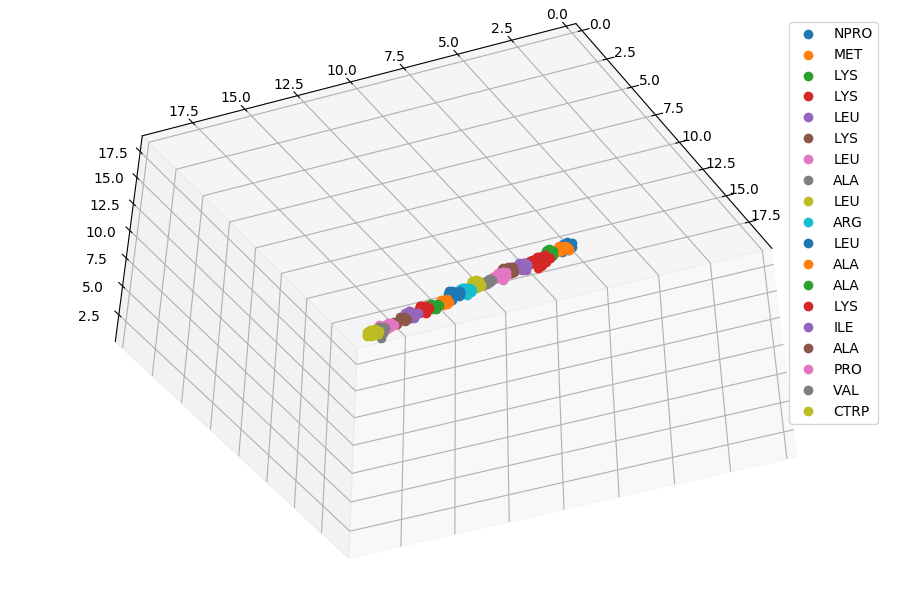

In [6]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

length_errors = []
for bond in chain.external_harmonic_bond_forces:
    dist = np.linalg.norm(bond.atom1.pos.numpy() - bond.atom2.pos.numpy())
    length_errors.append((dist - bond.length.numpy()) ** 2)
max_error = np.max(length_errors)
length_errors = np.array(length_errors) / max_error

for bond, error in zip(chain.external_harmonic_bond_forces, length_errors):
    pos = np.array([bond.atom1.pos.numpy(), bond.atom2.pos.numpy()])
    ax.plot(pos[:,0], pos[:,1], pos[:,2], c=(error, (1 - error), 0))

for res in chain.residues:
    length_errors = []
    for bond in res.harmonic_bond_forces:
        dist = np.linalg.norm(bond.atom1.pos.numpy() - bond.atom2.pos.numpy())
        length_errors.append((dist - bond.length.numpy()) ** 2)
    max_error = np.max(length_errors)
    length_errors = np.array(length_errors) / max_error
        
    for bond, error in zip(res.harmonic_bond_forces, length_errors):
        pos = np.array([bond.atom1.pos.numpy(), bond.atom2.pos.numpy()])
        ax.plot(pos[:,0], pos[:,1], pos[:,2], c=(error, (1 - error), 0))
        
    pos = np.array([atom.pos.numpy() for atom in res.atoms])
    ax.plot(pos[:,0], pos[:,1], pos[:,2], 'o', label=res.name)

plt.legend()
plt.tight_layout()
plt.show()

In [9]:
with open('proteins/6ct4.pred', 'wb') as file:
    pickle.dump(chain, file)